### Amazon Fine Food Reviews

__Objective:__ 

The data for this project comes from a dataset posted on kaggle.com. We are using the data to explore text mining, feature engineering and build a model to identify which features make a review on amazon helpful. This will not only help amazon in positioning their reviews in a way that improves customer's purchasing decision but also serve as a guide to writing helpful reviews.

To do so, we will work on the recommendation dataset to encode the text data using Bag of Words and count vectorization. When the data is ready, we will run a logistic regression model to find the most important features. 


__Data Overview:__ 

The dataset consists of ~500,00 reviews of fine foods from amazon. The data span a period of more than 10 years. 
Reviews include the following:

Variable: Description || Type of Variable
* ProductId: Unique id of the product being reviewed || string
* ProfileName: Profile name of the user || string
* HelpfulnessNumerator: number of users who found the review helpful || continuous
* HelpfulnessDenominator: number of users who indicated whether they found the review helpful or not helpful || continuous
* Score: rating between 1 and 5 || categorical
* Summary : Brief summary of the review || text
* Text: text of the review || text

__Analysis Approach:__

* I. Understanding the data 
* II. Data Cleaning 
* III. Feature Engineering :
    * Length of reviews
    * Words as features
        * Lemmatization and Stemming
        * Bag of Words 
        * Bigram 
    * Score as dummy variables
* IV. Preparing X and Y for model building**
* V. Model building - Logit, Logistics Regression, Gridsearch Logistics**
* VI. Interpretation
* VII. Finding and validation of finding
* VIII. Managerial Insights

** - Repeating step 4 and 5 for both bag of words (each word as a feature) and bigrams (single word as well as combination of two words). This is because in BOW it doesnt consider related words. For example, if we consider two reviews __This pasta is very tasty__ and __This pasta is not tasty__ after stopwords removal both sentences will be converted to pasta tasty so both giving exact same meaning.The main problem is here we are not considering the front and back words related to every word. So we use Bigram which will consider pair of words

Printing the output

In [51]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.set_option('precision', 2) # show only two decimal digits

Importing required packages:

In [52]:
import warnings
warnings.filterwarnings("ignore")                                   #Ignoring unnecessory warnings

import numpy as np                                                  #for large and multi-dimensional arrays                               #for data manipulation and analysis
import nltk 
nltk.download('stopwords')                                          #Natural language processing tool-kit
nltk.download('wordnet')
from nltk.corpus import stopwords                                   #Stopwords 
from nltk.stem import PorterStemmer                                 # Stemmer
from nltk.stem import WordNetLemmatizer                             # Lemmatizer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
import sklearn as sk
import sklearn.tree as tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from IPython.display import Image  
import pydotplus
import mglearn
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dakshatajain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dakshatajain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
plt.rcParams['figure.figsize'] = 10,6

__I. UNDERSTANDING THE DATA__:

Reading the file:

In [54]:
df = pd.read_csv('Reviews.csv')

In [55]:
df.loc[:,['ProductId','ProfileName','Text','Score','HelpfulnessNumerator','HelpfulnessDenominator']].head(2)

,ProductId,ProfileName,Text,Score,HelpfulnessNumerator,HelpfulnessDenominator
0,B001E4KFG0,delmartian,I have bought several of the Vitality canned d...,5,1,1
1,B00813GRG4,dll pa,Product arrived labeled as Jumbo Salted Peanut...,1,0,0


__Creating the subset:__ 
For the purpose of this analysis, we are considering the reviews which have been voted (i.e. helpful or not) for atleast 10 times. 

In [56]:
df_subset1 = df[(df.HelpfulnessDenominator > 10)]

__Creating Y variable: (Useful)__
We wanted to create a binary variable that will indicate whether a particular review was useful or not. In order to so we followed the following approach:
   1. Step 1: Compute the helpfulness i.e. fraction of total users that found the review helpful for each review as follows: 
        $$
         \frac{\#HelpfulnessNumerator }{\#HelpfulnessDenominator} 
        $$ 
   2. Step 2: 
       * Decide the threshold to create the useful variable. In order to do this, we inspected the distribution of data and observed that ~80% of the dataset had helpfulness greater than 50%. That is we cannot take 50% as the threshold.
       * In order to avoid creating an imbalanced dataset, we decided to subset the data by taking only __black and white__ areas. We filtered the records which have helpfulness as __1 - these will be the helpful reviews__ and helpfulness of __less than 0.4 - these will be the not helpful reviews__ 

After creating the subset: 
   * length of data - 8853
   * Records with helpful reviews (Useful = 1) - 5520 
   * Records with not helpful reviews (Useful = 0) - 3333

In [57]:
#Creating Helpfulness percentage:
df_subset1['helpfulness'] = (df.HelpfulnessNumerator / df.HelpfulnessDenominator)

In [58]:
#Subsetting further by taking only highly helpful (Perc_helfulness==1) and not at all helpful (Perc_helfulness<0.3):
df_subset2 = df_subset1[(df_subset1.helpfulness <= 0.4) | (df_subset1.helpfulness == 1)]

#Creating a dummy variable based on above which defines helpfulness:
df_subset2['Useful'] = (df_subset1.helpfulness == 1) * 1

__II. DATA CLEANING:__

__Cleaning the data by removing duplicates:__

In [59]:
# Identifying number of duplicates:
len(df_subset2) - len(df_subset2.groupby(['UserId','Text','ProfileName','Time'])) 

#Removing duplicates:
df1 = df_subset2.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

2475

__III. FEATURE ENGINEERING:__

__Feature 1. Length of the review__: The total length of review might impact the reader's interest in reading the review and hence impact its usefulness. The length of review has been computed by counting the number of words in a review.

In [60]:
df_subset2['Comment_Len']= df_subset2['Text'].apply(lambda x: len(str(x).split(' ')))

__Feature 2: Words in reviews:__ (Text cleaning and features)

__Step 1:__ Removing stop words (most commonly used english words like and, are, am, you etc.) from the reviews as we are interested only in the important words used in the reviews which might impact its usefulness. 

#### Creating a list for stopwords:

In [61]:
#Removing stopwords:
stop = set(stopwords.words('english')) 
print(stop)

{'theirs', 'were', 'whom', 'you', 'mightn', 'in', 'until', 'ain', 'against', 'yours', 'down', 'weren', "weren't", 'own', 'she', 'than', 'just', 'themselves', 'being', 'those', 'do', 'both', 'because', 'off', 'no', 'herself', 'very', 't', 'at', 's', 'after', "mustn't", 'is', 'these', 'itself', 'isn', "should've", 'as', 'now', 'haven', 'again', 'shouldn', "won't", 'few', 'once', 'which', 'll', 'over', 'wasn', 'nor', 'our', "you'll", "doesn't", 'into', 'what', 'during', 'that', 'not', 'don', 'hasn', 'when', 'there', 'some', 'been', 'have', 'ma', 'this', 'him', 'hers', 'above', 'only', "mightn't", "wouldn't", "that'll", 'so', 'having', 'her', 'mustn', 'was', 'his', 'below', 'out', 'wouldn', 'between', 'has', 'couldn', 'o', 'here', 'how', "you've", 'will', "wasn't", 'ourselves', "it's", 'they', 'aren', 'does', 'of', 'be', 'yourself', 'by', 'from', 'ours', 'other', "aren't", "haven't", 'any', 'won', 'further', 'same', 'each', 'for', "isn't", 'himself', "don't", 'such', "she's", 'd', 'my', 'a

In [62]:
#Updating the stopwords by not including words like NOt which are important:
stop_upd = {'here','just', 'before', 'other','whom', 'once', 'further', 'now', 'where',\
            'of', 'below', 'it', 'was','themselves', 't', 'been', 'a', 'had', \
            'when', 'those', 'is', 'your', 'out', "that'll",'he', 'have', 'yourself', \
            'more', 'what', 'which', "she's",'why', 'ours', "you'll", 'they', 've', \
            'after', 'we', 'be', 'being', 'off', 'herself', 'mightn', 'she', 'were', \
            'because', 'for', 'over', 'him', 'the','by','can', 'my', 'haven', 'are', 'd', \
            'and','itself', 'or', 'again', 'them','each', 'theirs', 'these', 'if', 're', \
            'does', 'do', 'than', 'am', 'from', 'only', 'about','in',"it's",'ma','any',  \
            'ourselves', 'some','through', 'ain','such','shan', 'their', 'into','did', 'yours',\
            'up', 'with', 'himself', 'on', 'her', 'm', 'our', 'll', 'under',  "you'd", 'won', 'hers',\
            'then', 'how', 'so', 'i', "you've", 'down', 'that', 'both', 'you', 'there', 'as', 'during', \
            'all', 'own', 'myself', 'above', 'to', 'same', 's', 'but', 'this', 'yourselves', 'his', \
            'until', 'doing', 'who', 'o', 'between', 'at', 'having', 'has', 'y', 'its', 'an', "you're", 'me', 'while'}

__Step 2__: Once the stop words are removed, we convert the words to its root form. This can be achieved using one of the two approaches:
  1. Stemming: converting the words to their pseudo root form. Eg: preparation, preparing becomes 'prepar'.
  2. Lemmatization : converting words to their root word which is an actual language word. Eg: preparation, preparing becomes 'prepare'. 

You may read in detail about stemming and lemmatization [here]
  
[here]:https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8

__1. Stemming__:

In [63]:
# Reassigning to df2
df2= df1[~df1.Summary.isna()]

#Cleaning Using Lemmatization:
temp = []
wordnet_stemmer = PorterStemmer()

for sentence in df2.Text:
    sentence = sentence.lower()                          # Converting to lowercase
    cleanr   = re.compile('<.*?>')                      
    sentence = re.sub(cleanr, ' ', sentence)             #Removing HTML tags   
    sentence = re.sub('[^a-z ]+',r'',sentence)          #Removing Punctuations, Numbers
    
    words = [wordnet_stemmer.stem(word) for word in sentence.split() if word not in stop_upd]   # Lemmatizing and removing stopwords
    temp.append(words)
        
X_initial = temp            

In [64]:
#Removing quotes from words:
list_words = []
for row in X_initial:
    s1 = ''
    for word in row:
        s1 = s1 + ' ' + word
    list_words.append(s1)

X_initial = list_words
print(X_initial[0])

 mccann instant oatmeal great must oatmeal scrape togeth two three minut prepar no escap fact howev even best instant oatmeal nowher near good even store brand oatmeal requir stovetop prepar still mccann good get instant oatmeal even better organ allnatur brand tri varieti mccann varieti pack tast good prepar microwav ad boil water conveni extrem time issu mccann use actual cane sugar instead high fructos corn syrup help decid buy product real sugar tast better not harm stuff one thing not like though mccann use thicken oat plu water plu heat should make creami tasti oatmeal without need guar gum conveni product mayb guar gum sit bowl instant mccann becom too thick gluey


__2. Lemmatization:__ 

In [65]:
# Reassigning to df2
df2= df1[~df1.Summary.isna()]

#Cleaning Using Lemmatization:
temp = []
wordnet_lemmatizer = WordNetLemmatizer()

for sentence in df2.Text:
    sentence = sentence.lower()                          # Converting to lowercase
    cleanr   = re.compile('<.*?>')                      
    sentence = re.sub(cleanr, ' ', sentence)             #Removing HTML tags   
    sentence = re.sub('[^a-z ]+',r'',sentence)          #Removing Punctuations, Numbers
    
    words = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in sentence.split() if word not in stop_upd]   # Lemmatizing and removing stopwords
    temp.append(words)
        
X_initial = temp            

In [66]:
#Removing quotes from words:
list_words = []
for row in X_initial:
    s1 = ''
    for word in row:
        s1 = s1 + ' ' + word
    list_words.append(s1)

X_initial = list_words
print(X_initial[0])

 mccanns instant oatmeal great must oatmeal scrape together two three minutes prepare no escape fact however even best instant oatmeal nowhere near good even store brand oatmeal require stovetop preparation still mccanns good get instant oatmeal even better organic allnatural brand try varieties mccanns variety pack taste good prepare microwave add boil water convenient extreme time issue mccanns use actual cane sugar instead high fructose corn syrup help decide buy product real sugar taste better not harmful stuff one thing not like though mccanns use thickeners oats plus water plus heat should make creamy tasty oatmeal without need guar gum convenience product maybe guar gum sit bowl instant mccanns become too thick gluey


__Step 3:__ Creating vectors for words in reviews. This means that each word becomes a column with the value equal to number of times that word appears in that review. In order to so, we will use single matrix bag of words technique.

__Bag of Words:__

In [67]:
#matrix of words 
count_vect = CountVectorizer(max_features=1000,min_df=30)
text_matrix = count_vect.fit_transform(X_initial)

In [68]:
#Converting its output in df:
text_vect = pd.DataFrame(text_matrix.todense(), columns=count_vect.get_feature_names())

In [69]:
#Merging the two dataframes:
df2.index = text_vect.index
df_text = pd.merge(df2, text_vect, left_index=True, right_index=True)

__Feature 3: Score__ Converting score (1-5) into dummy variables because we want to evaluate the impact of each of the score independently.

In [70]:
#Converting score column to dummies:
df_text = pd.get_dummies(df_text,columns=['Score'])

__IV. PREPARING X AND Y FOR MODEL BUILDING:__

In [71]:
#Creating X and Y
X_text = df_text.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator',\
                    'HelpfulnessDenominator','Time','Summary','Text','Useful','helpfulness'])
Y_text = df_text.Useful

In [72]:
X_train,X_test,Y_train,Y_test = train_test_split(X_text,Y_text,test_size = 0.3,random_state=0)

__V. MODEL BUILDING__: We run the models to test the significance of coefficients. We started with logit model that will let us know if a feature (word) is significant or not 

__1. Logit Model:__

In [73]:
logit_model=sm.Logit(Y_text,X_text)
result=logit_model.fit(maxiter=10000)
#result.summary2()

Optimization terminated successfully.
         Current function value: 0.176329
         Iterations 11


__2. Logistics Regression:__

In [74]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train, Y_train)
y_pred=logreg.predict(X_test)

In [75]:
#Getting the log reg coefficients:
#words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame( data = list(zip(X_text.columns, logreg_result.coef_[0])),columns = ['feature', 'coef']) 
feature_coefs.sort_values(by='coef').head(5)

,feature,coef
141,chemicals,-8.07
108,bunch,-7.59
642,possible,-7.54
1001,Score_2,-7.10
633,play,-7.08


In [76]:
feature_coefs.sort_values(by='coef').tail(5)

,feature,coef
710,rinse,12.12
864,tend,12.51
699,require,13.24
175,concentrate,15.43
544,mushroom,17.80


Optional: Predicting on test dataset

In [77]:
confusion_matrix(Y_test,y_pred)

array([[511, 191],
       [222, 990]])

In [78]:
# Accuracy:
1 - (y_pred - Y_test ).abs().mean()

0.7842215256008359

__3. Gridsearch CV logistics method to find the top 25 features:__

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best cross-validation score: 0.88
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


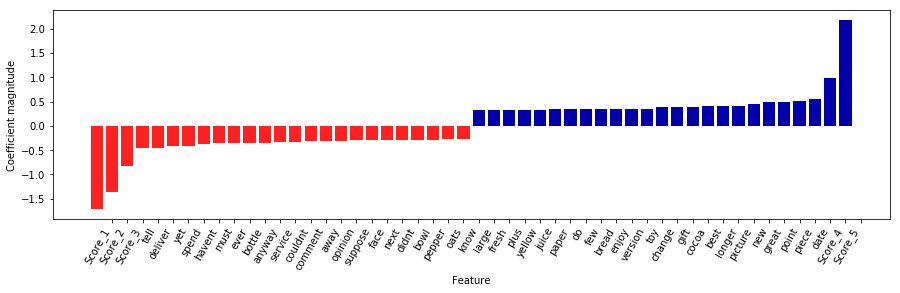

In [79]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, Y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, X_test.columns, n_top_features=25)
plt.show()

__REPEATING STEP IV and V FOR BIGRAM:__

__Bigram :__ As mentioned earlier in case of reviews it is important to consider front and back related words to extract whether the review was positive or negative.

In [80]:
#Reassigning:
Final_X = X_initial 

In [81]:
#Bigram:
count_vect = CountVectorizer(ngram_range=(1,2),min_df=20)
Bigram_data_text = count_vect.fit_transform(Final_X)
print(Bigram_data_text[1])

  (0, 283)	1
  (0, 2595)	1
  (0, 118)	1
  (0, 931)	1
  (0, 2535)	1
  (0, 20)	1
  (0, 2104)	1
  (0, 281)	1
  (0, 1517)	1
  (0, 419)	1
  (0, 124)	1
  (0, 568)	1
  (0, 682)	2
  (0, 1597)	1
  (0, 449)	1
  (0, 973)	1
  (0, 2191)	1
  (0, 673)	2
  (0, 2482)	1
  (0, 509)	1
  (0, 335)	1
  (0, 2615)	1
  (0, 1487)	1
  (0, 1902)	1
  (0, 1745)	1
  (0, 1678)	1
  (0, 2486)	1
  (0, 508)	1
  (0, 1181)	1
  (0, 1290)	1
  (0, 2445)	3
  (0, 334)	1
  (0, 2711)	1
  (0, 2590)	1
  (0, 212)	2
  (0, 2122)	1
  (0, 266)	1
  (0, 1065)	2
  (0, 205)	2
  (0, 2577)	1
  (0, 1097)	1
  (0, 1744)	2
  (0, 1287)	1


In [82]:
#Converting its output in df:
count_vect_df_bigram = pd.DataFrame(Bigram_data_text.todense(), columns=count_vect.get_feature_names())

In [83]:
#Merging the two dataframes:
df2.index = count_vect_df_bigram.index
df3_bigram_merged = pd.merge(df2, count_vect_df_bigram, left_index=True, right_index=True)

In [84]:
#Converting score column to dummies:
df3_bigram = pd.get_dummies(df3_bigram_merged,columns=['Score'])

In [85]:
#Creating X and Y
X = df3_bigram.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator',\
                    'HelpfulnessDenominator','Time','Summary','Text','Useful','helpfulness'])
Y = df3_bigram.Useful

In [86]:
#Splitting data into train and test
X_train,X_test,Y_training,Y_test = train_test_split(X,Y,test_size = 0.3,random_state=0)

In [87]:
#Running logistics regression:
logreg_BG = LogisticRegression(C=1e5) 
logreg_result_BG = logreg_BG.fit(X_train, Y_training) 
y_pred_BG = logreg_result_BG.predict(X_test)

In [88]:
#Getting the log reg coefficients:
feature_coefs = pd.DataFrame( data = list(zip(X.columns, logreg_result_BG.coef_[0])),columns = ['feature', 'coef']) 
feature_coefs.sort_values(by='coef').head(5)

,feature,coef
1592,money buy,-11.35
2971,Score_2,-10.37
1983,professional,-10.06
116,anyway,-9.85
115,anytime,-9.62


In [89]:
# Accuracy:
1 - (y_pred_BG - Y_test ).abs().mean()

0.8040752351097179

In [90]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, Y_training)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best cross-validation score: 0.88
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


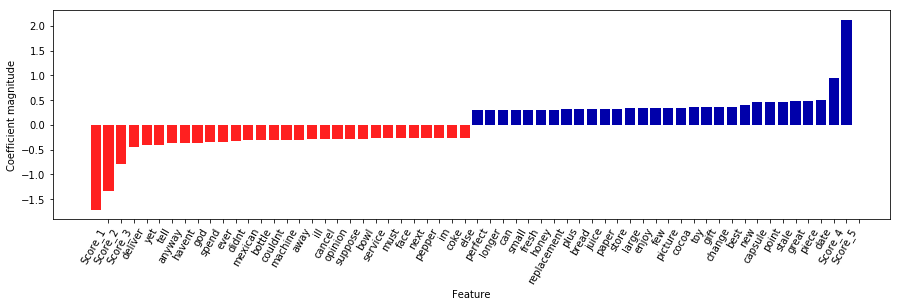

In [91]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, X.columns, n_top_features=30)
plt.show()

The above graph indicates that score (1,2,3,4,5) have are extremely important features along with words such as deliver, great, stale etc.

__VI. INTERPRETATION:__

__Analyzing the features:__

__Part 1: Feature : SCORE__

From the analysis done above, it can be inferred that, with __increase in the product rating, the usefulness increases__. However, this seems to be __counterintuitive__ as extreme product rating(1,5) should also have indicated high usefulness.

For Eg: The review with product rating '1' indicates a strong opinion about the purchase made, thus helping the customer reading the review make an informed decision. This is synonymous in terms of <b>helpfulness</b> with a review with product rating '5'.

This can be because customers are biased towards marking a review as not useful when they perceive the product quality to be low. This indicates that there is a correlation between the usefulness indicator and product quality

The score feature can be validated using the seaborn plot:

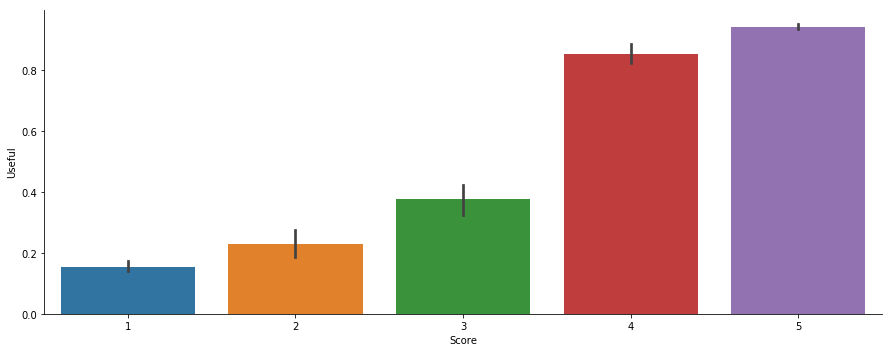

In [92]:
sns.catplot(data=df3_bigram_merged, y = 'Useful',x='Score',
           kind = 'bar',aspect=2.5)

#### Part 2: 
<li> Though in general the trend for Usefulness for lower ratings (1,2,3) is decreasing, we look at some of the top features to confirm if they follow the same pattern

<li> Getting the average usefulness of some of the top features (great,best,suppose) for each score/ratings

In [93]:
df_Final = df3_bigram_merged[['Score','Useful','great','best','suppose']]
df_Final['Binned_Score_less_than_3'] = (df_Final.Score <= 3 ) * 1

In [94]:
df_1 = df_Final[(df_Final.great < 2 )]
df_1.groupby(['great','Score'])['Useful'].mean()

great  Score
0      1        0.15
       2        0.23
       3        0.36
       4        0.82
       5        0.93
1      1        0.23
       2        0.25
       3        0.45
       4        0.95
       5        0.98
Name: Useful, dtype: float64

In [95]:
df_2 = df_Final[(df_Final.best < 2 )]
df_2.groupby(['best','Score'])['Useful'].mean()

best  Score
0     1        0.15
      2        0.23
      3        0.38
      4        0.84
      5        0.93
1     1        0.32
      2        0.24
      3        0.38
      4        0.94
      5        0.97
Name: Useful, dtype: float64

In [96]:
df_3 = df_Final[(df_Final.suppose < 2 )]
df_3.groupby(['suppose','Score'])['Useful'].mean()

suppose  Score
0        1        0.16
         2        0.23
         3        0.38
         4        0.86
         5        0.94
1        1        0.14
         2        0.09
         3        0.29
         4        0.69
         5        0.98
Name: Useful, dtype: float64

__VII. FINDING AND VALIDATION OF FINDING:__


<ul>
<li> If the rating is greater than 4, the appearance of any word does not significantly impact the usefulness </li>
<li> However, if the review has opinion words  like 'great','best' etc., then with the appearance of the words, the usefulness seems to increase even if the product rating provided is lower </li>
<li> Also, if the words are neutral and ambiguous like 'suppose','anyway' etc. the usefulness seems to decrease with the appearance of the word

The following graphs can validate the above finding:

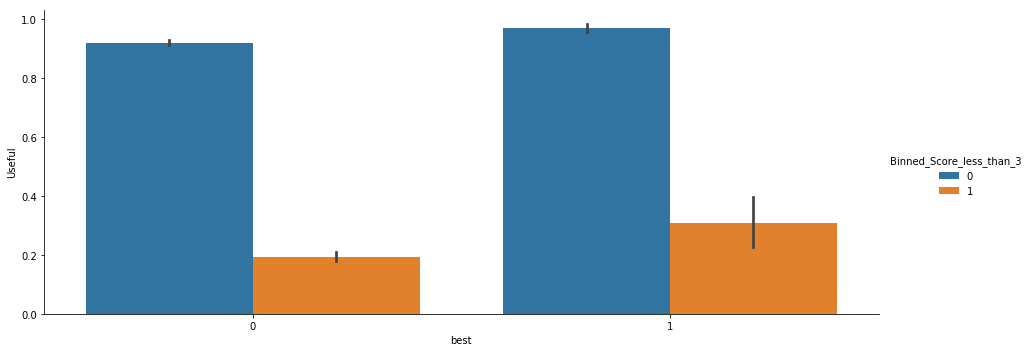

In [97]:
sns.catplot(data=df_2, y = 'Useful',x='best',
           kind = 'bar',aspect=2.5, hue = 'Binned_Score_less_than_3')

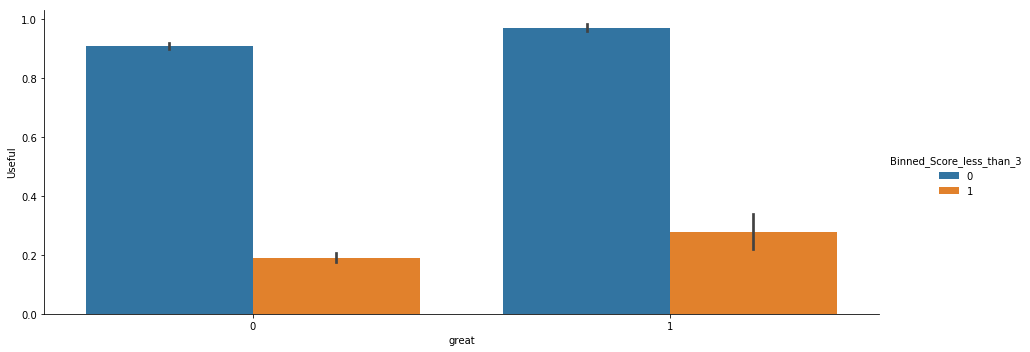

In [98]:
sns.catplot(data=df_1, y = 'Useful',x='great',
           kind = 'bar',aspect=2.5, hue = 'Binned_Score_less_than_3')

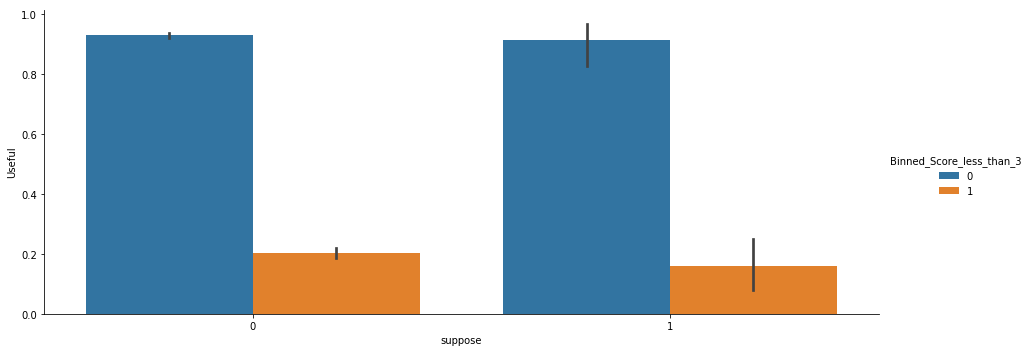

In [99]:
sns.catplot(data=df_3, y = 'Useful',x='suppose',
           kind = 'bar',aspect=2.5, hue = 'Binned_Score_less_than_3')

__VIII. MANAGERIAL INSIGHTS:__

<ul>
    <li> Using the above finding, the positioning of the reviews can be changed so that they are most useful to the customers and can help customers make an informed purchase decision.</li>
    <li> For Eg: The reviews with highest rating and the ones which consists of superlative words should be displayed on the top</li>
    <li>As the customers are correlating the helpfulness and bad product rating, the option to vote 'Not helpful' should be removed as it is resulting in biased information.